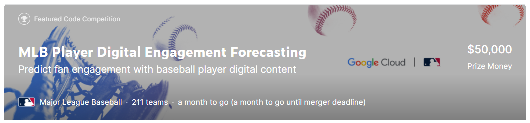

### CREDITS
https://www.kaggle.com/ulrich07/mlb-ann-with-lags-tf-keras
thanks. I copied your code.

ミッション：このコンテストでは、将来の日付範囲でファンがMLBプレーヤーのデジタルコンテンツに毎日どのように関与するかを予測します。 プレーヤーのパフォーマンスデータ、ソーシャルメディアデータ、市場規模などのチーム要因にアクセスできます。 成功したモデルは、どのシグナルがエンゲージメントと最も強く相関し、影響を与えるかについての新しい洞察を提供します。

研究しているのでしばらくお待ちください。インターネットを検索すると、半年で金メダルとりました、みたいな記事がいろいろでてくるのですが。。。<br>
私にはまったく手ごたえがありません。<br>

コンペの一番優しいものを選択してそれに集中しようとしています。<br>
しかし、全部ムズカシイ。どうしようもないので、全部手をだして絞っていこうとおもっています。<br>

MLBのコンペはこれは２つ目のコードなのですが、手法が違うようです。<br>
このコードは、しばらくおいておこうかな<br>
愚痴書いて、今日は終わりということで。

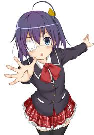

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
from tqdm import tqdm
import gc
from functools import reduce
from sklearn.model_selection import StratifiedKFold

In [ ]:
def make_df(df, col, bool_in=False):
    tp = df.loc[ ~df[col].isnull() ,[col]].copy()
    df.drop(col, axis=1, inplace=True)
    
    tp[col] = tp[col].str.replace("null",'""')
    if bool_in:
        tp[col] = tp[col].str.replace("false",'"False"')
        tp[col] = tp[col].str.replace("true",'"True"')
    tp[col] = tp[col].apply(lambda x: eval(x) )
    a = tp[col].sum()
    gc.collect()
    return pd.DataFrame(a)

In [ ]:
ROOT_DIR = "../input/mlb-player-digital-engagement-forecasting"

## UTILITY FUNCTIONS

In [ ]:
#=======================#
def flatten(df, col):
    du = (df.pivot(index="playerId", columns="EvalDate", 
               values=col).add_prefix(f"{col}_").
      rename_axis(None, axis=1).reset_index())
    return du
#============================#
def reducer(left, right):
    return left.merge(right, on="playerId")
#========================

In [ ]:
TGTCOLS = ["target1","target2","target3","target4"]
def train_lag(df, lag=1):
    dp = df[["playerId","EvalDate"]+TGTCOLS].copy()
    dp["EvalDate"]  =dp["EvalDate"] + timedelta(days=lag) 
    df = df.merge(dp, on=["playerId", "EvalDate"], suffixes=["",f"_{lag}"], how="left")
    return df
#=================================
def test_lag(sub):
    sub["playerId"] = sub["date_playerId"].apply(lambda s: int(  s.split("_")[1]  ) )
    assert sub.date.nunique() == 1
    dte = sub["date"].unique()[0]
    
    eval_dt = pd.to_datetime(dte, format="%Y%m%d")
    dtes = [eval_dt + timedelta(days=-k) for k in LAGS]
    mp_dtes = {eval_dt + timedelta(days=-k):k for k in LAGS}
    
    sl = LAST.loc[LAST.EvalDate.between(dtes[-1], dtes[0]), ["EvalDate","playerId"]+TGTCOLS].copy()
    sl["EvalDate"] = sl["EvalDate"].map(mp_dtes)
    du = [flatten(sl, col) for col in TGTCOLS]
    du = reduce(reducer, du)
    return du, eval_dt
    #
#===============

In [ ]:
%%time
#tr = pd.read_csv(f"{ROOT_DIR}/train.csv")
tr = pd.read_csv("../input/mlb-data/target.csv")
print(tr.shape)
gc.collect()

In [ ]:
tr["EvalDate"] = pd.to_datetime(tr["EvalDate"])
tr["EvalDate"] = tr["EvalDate"] + timedelta(days=-1)
tr["EvalYear"] = tr["EvalDate"].dt.year

In [ ]:
MED_DF = tr.groupby(["playerId","EvalYear"])[TGTCOLS].median().reset_index()
MEDCOLS = ["tgt1_med","tgt2_med", "tgt3_med", "tgt4_med"]
MED_DF.columns = ["playerId","EvalYear"] + MEDCOLS

In [ ]:
MED_DF.head()

In [ ]:
LAGS = list(range(1,31))
FECOLS = [f"{col}_{lag}" for lag in reversed(LAGS) for col in TGTCOLS]

In [ ]:
%%time
for lag in tqdm(LAGS):
    tr = train_lag(tr, lag=lag)
    gc.collect()
#===========
tr = tr.sort_values(by=["playerId", "EvalDate"])
print(tr.shape)
tr = tr.dropna()
print(tr.shape)
tr = tr.merge(MED_DF, on=["playerId","EvalYear"])
gc.collect()

In [ ]:
tr.head()

In [ ]:
X = tr[FECOLS+MEDCOLS].values
y = tr[TGTCOLS].values
cl = tr["playerId"].values

In [ ]:
NFOLDS = 5
skf = StratifiedKFold(n_splits=NFOLDS)
folds = skf.split(X, cl)
folds = list(folds)

In [ ]:
X.shape

## Neural Net Training

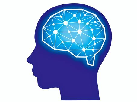

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

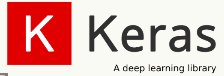

In [ ]:
def make_model(n_in):
    inp = L.Input(name="inputs", shape=(n_in,))
    x = L.Dense(50, activation="relu", name="d1")(inp)
    x = L.Dense(50, activation="relu", name="d2")(x)
    preds = L.Dense(4, activation="linear", name="preds")(x)
    
    model = M.Model(inp, preds, name="ANN")
    model.compile(loss="mean_absolute_error", optimizer="adam")
    return model

I think this model is simple. but its effective.

In [ ]:
net = make_model(X.shape[1])
print(net.summary())

In [ ]:
oof = np.zeros(y.shape)
nets = []
EPOCHS  = 15
for idx in range(NFOLDS):
    print("FOLD:", idx)
    tr_idx, val_idx = folds[idx]
    ckpt = ModelCheckpoint(f"w{idx}.h5", monitor='val_loss', verbose=1, save_best_only=True,mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=3, min_lr=0.0005)
    es = EarlyStopping(monitor='val_loss', patience=6)
    reg = make_model(X.shape[1])
    reg.fit(X[tr_idx], y[tr_idx], epochs=EPOCHS, batch_size=30_000, 
            validation_data=(X[val_idx], y[val_idx]),
            verbose=1, callbacks=[ckpt, reduce_lr, es])
    reg.load_weights(f"w{idx}.h5")
    oof[val_idx] = reg.predict(X[val_idx], batch_size=50_000, verbose=1)
    nets.append(reg)
    gc.collect()
    #
#

In [ ]:
mae = mean_absolute_error(y, oof)
mse = mean_squared_error(y, oof, squared=False)
print("mae:", mae)
print("mse:", mse)

In [ ]:
# Historical information to use in prediction time
bound_dt = pd.to_datetime("2021-01-01")
LAST = tr.loc[tr.EvalDate>bound_dt].copy()

In [ ]:
LAST_MED_DF = MED_DF.loc[MED_DF.EvalYear==2021].copy()
LAST_MED_DF.drop("EvalYear", axis=1, inplace=True)
del tr

In [ ]:
LAST.shape, LAST_MED_DF.shape, MED_DF.shape

In [ ]:
#nets[0].summary()

In [ ]:
#"""
import mlb
FE = []; SUB = [];
env = mlb.make_env() # initialize the environment
iter_test = env.iter_test() # iterator which loops over each date in test set

for (test_df, sub) in iter_test:
    # Features computation at Evaluation Date
    sub = sub.reset_index()
    sub_fe, eval_dt = test_lag(sub)
    sub_fe = sub_fe.merge(LAST_MED_DF, on="playerId", how="left")
    sub_fe = sub_fe.fillna(0.)
    
    _preds = 0.
    for reg in nets:
        _preds += reg.predict(sub_fe[FECOLS + MEDCOLS]) / NFOLDS
    sub_fe[TGTCOLS] = np.clip(_preds, 0, 100)
    sub.drop(["date"]+TGTCOLS, axis=1, inplace=True)
    sub = sub.merge(sub_fe[["playerId"]+TGTCOLS], on="playerId", how="left")
    sub.drop("playerId", axis=1, inplace=True)
    sub = sub.fillna(0.)
    # Submit
    env.predict(sub)
    # Update Available information
    sub_fe["EvalDate"] = eval_dt
    #sub_fe.drop(MEDCOLS, axis=1, inplace=True)
    LAST = LAST.append(sub_fe)
    LAST = LAST.drop_duplicates(subset=["EvalDate","playerId"], keep="last")
#"""

In [ ]:
sub.head()

In [ ]:
LAST.shape, sub_fe.shape

In [ ]:
#df_tr["dte"] = pd.to_datetime(df_tr["date"], format='%Y%m%d')